In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../src/')

import matplotlib.cm as cm
from profiles import NFW,Green
import os
import jsm_prephalo
import jsm_stats
import galhalo
import jsm_halopull
import scipy.stats

from scipy.optimize import curve_fit


In [2]:
def surviving_frac(lgMh_mat, z_mat, surv_mask):

    binm = np.linspace(8,12,21)
    binz = np.linspace(0,12,21) 

    stack_histo = np.zeros(shape=(lgMh_mat.shape[0], 20, 20))
    stack_histo_surv = np.zeros(shape=(lgMh_mat.shape[0], 20, 20))

    lgMh_mat_surv = np.ma.filled(np.ma.masked_array(lgMh_mat, mask=~surv_mask),fill_value=np.nan) # now selecting only those that are above mlres
    z_mat_surv = np.ma.filled(np.ma.masked_array(z_mat, mask=~surv_mask),fill_value=np.nan)   
   
    for i in range(lgMh_mat.shape[0]):
        stack_histo[i,:,:] = np.histogram2d(lgMh_mat[i], z_mat[i], bins=(binm, binz))[0]    
        stack_histo_surv[i,:,:] = np.histogram2d(lgMh_mat_surv[i], z_mat_surv[i], bins=(binm, binz))[0]

    cross_histo = np.nansum(stack_histo, axis=0)
    cross_histo_surv = np.nansum(stack_histo_surv, axis=0)
    image = cross_histo_surv/cross_histo

    return image

# plt.xlabel("log M$_{peak}$")
# plt.ylabel("z$_{peak}$")

In [3]:
mass = np.load("../../data/perfect-MW-analog/acc_mass_10k.npy")
red = np.load("../../data/perfect-MW-analog/acc_redshift_10k.npy")
mask = np.load("../../data/perfect-MW-analog/surv_mask_10k.npy")

In [4]:
mass = np.delete(mass, 0, axis=1)/1e12
mask = np.delete(mask, 0, axis=1)
red = np.delete(red, 0, axis=1)

In [5]:
binm = np.linspace(-4,0,41)
binz = np.linspace(0,15,41)
bincentersm = 0.5 * (binm[1:] + binm[:-1])
bincentersz = 0.5 * (binz[1:] + binz[:-1])

In [6]:
acc_mass = np.log10(mass.flatten())
acc_red = red.flatten()

hist_acc, xedges, yedges = np.histogram2d(acc_mass, acc_red, (binm, binz))

/var/folders/wm/2wnpbn757m34vprj1hp7hwzw0000gn/T/ipykernel_10072/1743775486.py:1: RuntimeWarning: divide by zero encountered in log10
  acc_mass = np.log10(mass.flatten())


In [7]:
surv_mass = np.log10(np.ma.filled(np.ma.masked_array(mass, mask=~mask),fill_value=np.nan).flatten())
surv_red = np.ma.filled(np.ma.masked_array(red, mask=~mask),fill_value=np.nan).flatten()

hist_surv, xedges, yedges = np.histogram2d(surv_mass, surv_red, (binm, binz))

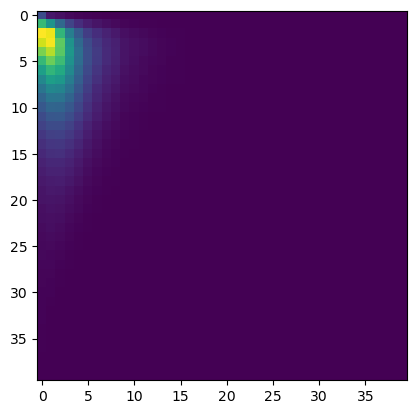

In [8]:
plt.imshow(hist_surv)
plt.show()

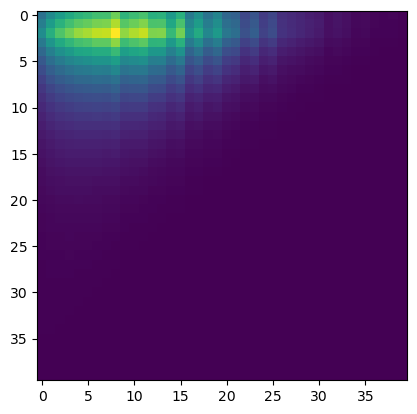

In [9]:
plt.imshow(hist_acc)
plt.show()

In [10]:
wow = hist_surv/hist_acc

image = np.rot90(wow)

/var/folders/wm/2wnpbn757m34vprj1hp7hwzw0000gn/T/ipykernel_10072/88918332.py:1: RuntimeWarning: invalid value encountered in divide
  wow = hist_surv/hist_acc


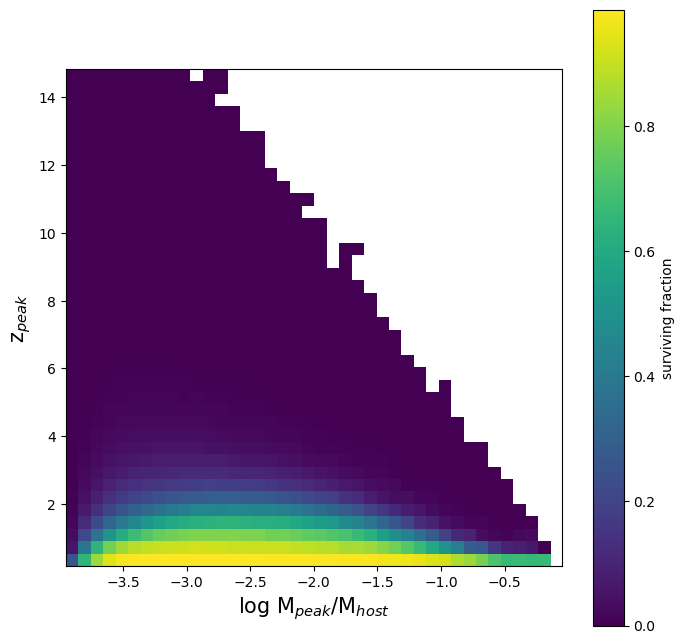

In [11]:
fig,ax=plt.subplots(figsize=(8,8))
im = ax.imshow(image, extent=[bincentersm.min(), bincentersm.max(), bincentersz.min(), bincentersz.max()])

ax.set_aspect(1/ax.get_data_ratio(), adjustable="box")
fig.colorbar(im, label="surviving fraction")
plt.xlabel("log M$_{peak}$/M$_{host}$", fontsize=15)
plt.ylabel("z$_{peak}$", fontsize=15)
plt.show()

In [12]:
def get_basis(x, y, max_order):
    """Return the fit basis polynomials: 1, x, x^2, ..., xy, x^2y, ... etc."""
    basis = []
    for i in range(max_order+1):
        for j in range(max_order - i +1):
            basis.append(x**j * y**i)
    return basis


In [13]:
X, Y = np.meshgrid(bincentersm, bincentersz)
x, y = X.ravel(), Y.ravel()
image[np.isnan(image)]=0
Z=image

In [14]:
# We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
x, y = X.ravel(), Y.ravel()
# Maximum order of polynomial term in the basis.
max_order = 3
basis = get_basis(x, y, max_order)
# Linear, least-squares fit.
A = np.vstack(basis).T
b = Z.ravel()
c, r, rank, s = np.linalg.lstsq(A, b, rcond=None)

print('Fitted parameters:')
print(c)

# Calculate the fitted surface from the coefficients, c.
fit = np.sum(c[:, None, None] * np.array(get_basis(X, Y, max_order))
                .reshape(len(basis), *X.shape), axis=0)

rms = np.sqrt(np.mean((Z - fit)**2))
print('RMS residual =', rms)


Fitted parameters:
[-0.02191605  0.21673209  0.09914686  0.01092872  0.11753543 -0.01530796
 -0.00730628 -0.02639834 -0.00135609  0.00134151]
RMS residual = 0.09044682250607243


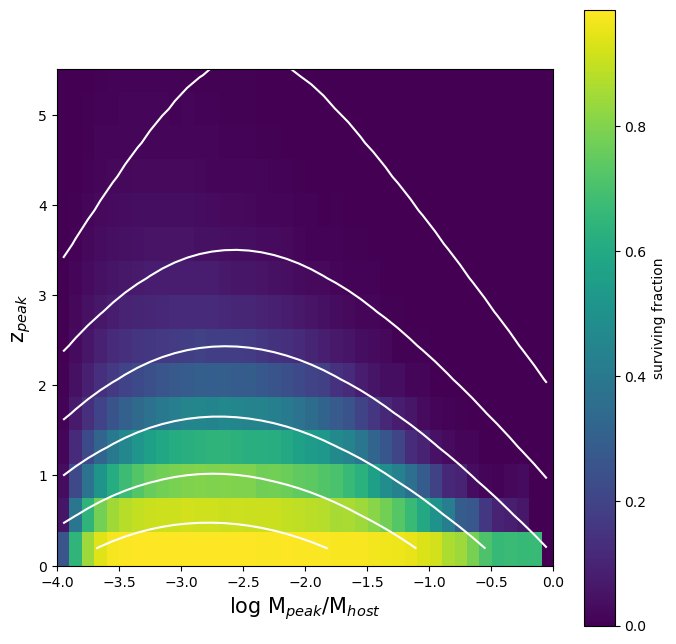

In [15]:

fig,ax=plt.subplots(figsize=(8,8))
im = ax.imshow(image, extent=[binm.min(), binm.max(), binz.min(), binz.max()])
ax.contour(X, Y, np.rot90(fit.T), colors='white')
ax.set_ylim(binz.min(), 5.5)
ax.set_aspect(1/ax.get_data_ratio(), adjustable="box")
fig.colorbar(im, label="surviving fraction")
plt.xlabel("log M$_{peak}$/M$_{host}$", fontsize=15)
plt.ylabel("z$_{peak}$", fontsize=15)
plt.show()

https://scipython.com/blog/linear-least-squares-fitting-of-a-two-dimensional-data/